In [1]:
! pip install pytorch-ignite
! pip install torchsummary

In [2]:
from torch import cat
from torch.nn import BatchNorm2d, Conv2d, ConvTranspose2d, MaxPool2d, Module, \
    ModuleList, Sequential
from torch.nn.functional import relu


def conv(in_channels, out_channels, kernel_size=3, padding=1, batch_norm=True):
    c = Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1,
               padding=padding)
    if batch_norm:
        bn = BatchNorm2d(out_channels)
        return Sequential(c, bn)
    return c


class DownConv(Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv_in = conv(self.in_channels, self.out_channels)
        self.conv_out = conv(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = relu(self.conv_in(x))
        x = relu(self.conv_out(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(Module):
    def __init__(self,
                 in_channels,
                 out_channels):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.upconv = ConvTranspose2d(self.in_channels, self.out_channels,
                                      kernel_size=2, stride=2)

        self.conv_in = conv(2 * self.out_channels, self.out_channels)
        self.conv_out = conv(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up, output_size=from_down.size())
        x = cat((from_up, from_down), 1)
        x = relu(self.conv_in(x))
        x = relu(self.conv_out(x))
        return x


class SegmentationUNet(Module):
    def __init__(self, num_classes, device, in_channels=3, depth=5,
                 start_filts=64):
        super(SegmentationUNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        self.device = device

        self.down_convs = []
        self.up_convs = []

        outs = 0
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts * (2 ** i)
            pooling = True if i < depth - 1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth - 1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs)
            self.up_convs.append(up_conv)

        self.conv_final = conv(outs, self.num_classes, kernel_size=1, padding=0,
                               batch_norm=False)

        self.down_convs = ModuleList(self.down_convs)
        self.up_convs = ModuleList(self.up_convs)

    def forward(self, x):
        x = x.to(self.device)
        encoder_outs = []

        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        return x


In [3]:
from numpy import array, moveaxis
from PIL import Image
from torch import from_numpy
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size, num_classes, device):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.size = size
        self.num_classes = num_classes
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = array(
                Image.open(self.image_paths[idx]).resize((self.size, self.size),
                                                         resample=Image.BILINEAR))
        image = image / 255
        mask = array(
                Image.open(self.mask_paths[idx]).resize((self.size, self.size),
                                                        resample=Image.NEAREST),
                dtype='int')[:, :, 0]
        image = moveaxis(image, -1, 0)
        image = from_numpy(image).float().to(self.device)
        mask = moveaxis(mask, -1, 0)
        mask = from_numpy(mask).long().to(self.device)
        return image, mask


In [4]:
import numpy as np
import torch
from torch.nn import Module
from torch.nn.functional import cross_entropy, softmax


class TverskyCrossEntropyDiceWeightedLoss(Module):
    def __init__(self, num_classes, device):
        super(TverskyCrossEntropyDiceWeightedLoss, self).__init__()
        self.num_classes = num_classes
        self.device = device

    def tversky_loss(self, pred, target, alpha=0.5, beta=0.5):
        target_oh = torch.eye(self.num_classes)[target.squeeze(1)]
        target_oh = target_oh.permute(0, 3, 1, 2).float()
        probs = softmax(pred, dim=1)
        target_oh = target_oh.type(pred.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        inter = torch.sum(probs * target_oh, dims)
        fps = torch.sum(probs * (1 - target_oh), dims)
        fns = torch.sum((1 - probs) * target_oh, dims)
        t = (inter / (inter + (alpha * fps) + (beta * fns))).mean()
        return 1 - t

    def class_dice(self, pred, target, epsilon=1e-6):
        pred_class = torch.argmax(pred, dim=1)
        dice = np.ones(self.num_classes)
        for c in range(self.num_classes):
            p = (pred_class == c)
            t = (target == c)
            inter = (p * t).sum().float()
            union = p.sum() + t.sum() + epsilon
            d = 2 * inter / union
            dice[c] = 1 - d
        return torch.from_numpy(dice).float()

    def forward(self, pred, target, cross_entropy_weight=0.5,
                tversky_weight=0.5):
        if cross_entropy_weight + tversky_weight != 1:
            raise ValueError('Cross Entropy weight and Tversky weight should '
                             'sum to 1')
        ce = cross_entropy(pred, target,
                           weight=self.class_dice(pred, target).to(self.device))
        tv = self.tversky_loss(pred, target)
        loss = (cross_entropy_weight * ce) + (tversky_weight * tv)
        return loss


In [5]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

# from SegmentationDataset import SegmentationDataset
# from SegmentationUNet import SegmentationUNet
# from TverskyCrossEntropyDiceWeightedLoss import \
#     TverskyCrossEntropyDiceWeightedLoss


class SegmentationAgent:
    def __init__(self, val_percentage, test_num, num_classes,
                 batch_size, img_size, data_path, shuffle_data,
                 learning_rate, device):
        self.device = device
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_list, self.masks_list = self.load_data(data_path)
        train_split, val_split, test_split = self.make_splits(
            val_percentage, test_num, shuffle_data)
        self.train_loader = self.get_dataloader(train_split)
        self.validation_loader = self.get_dataloader(val_split)
        self.test_loader = self.get_dataloader(test_split)
        self.model = SegmentationUNet(self.num_classes, self.device)
        self.criterion = TverskyCrossEntropyDiceWeightedLoss(self.num_classes,
                                                             self.device)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.model.to(self.device)

    def load_data(self, path):
        images_list = list(path.glob('*/*/CameraRGB/*.png'))
        masks_list = list(path.glob('*/*/CameraSeg/*.png'))
        if len(images_list) != len(masks_list):
            raise ValueError('Invalid data loaded')
        images_list = np.array(images_list)
        masks_list = np.array(masks_list)
        return images_list, masks_list

    def make_splits(self, val_percentage, test_num, shuffle=True):
        if shuffle:
            shuffle_idx = np.random.permutation(range(len(self.images_list)))
            self.images_list = self.images_list[shuffle_idx]
            self.masks_list = self.masks_list[shuffle_idx]

        val_num = len(self.images_list) - int(val_percentage * len(
                self.images_list))
        train_images = self.images_list[:val_num]
        train_masks = self.masks_list[:val_num]

        validation_images = self.images_list[val_num:-test_num]
        validation_masks = self.masks_list[val_num:-test_num]

        test_images = self.images_list[-test_num:]
        test_masks = self.masks_list[-test_num:]

        return (train_images, train_masks), \
               (validation_images, validation_masks), \
               (test_images, test_masks)
    
    def get_dataloader(self, split):
        return DataLoader(SegmentationDataset(split[0], split[1], self.img_size,
                                              self.num_classes, self.device),
                          self.batch_size, shuffle=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,928
       BatchNorm2d-4         [-1, 64, 224, 224]             128
         MaxPool2d-5         [-1, 64, 112, 112]               0
          DownConv-6  [[-1, 64, 112, 112], [-1, 64, 224, 224]]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
       BatchNorm2d-8        [-1, 128, 112, 112]             256
            Conv2d-9        [-1, 128, 112, 112]         147,584
      BatchNorm2d-10        [-1, 128, 112, 112]             256
        MaxPool2d-11          [-1, 128, 56, 56]               0
         DownConv-12  [[-1, 128, 56, 56], [-1, 128, 112, 112]]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
      Bat

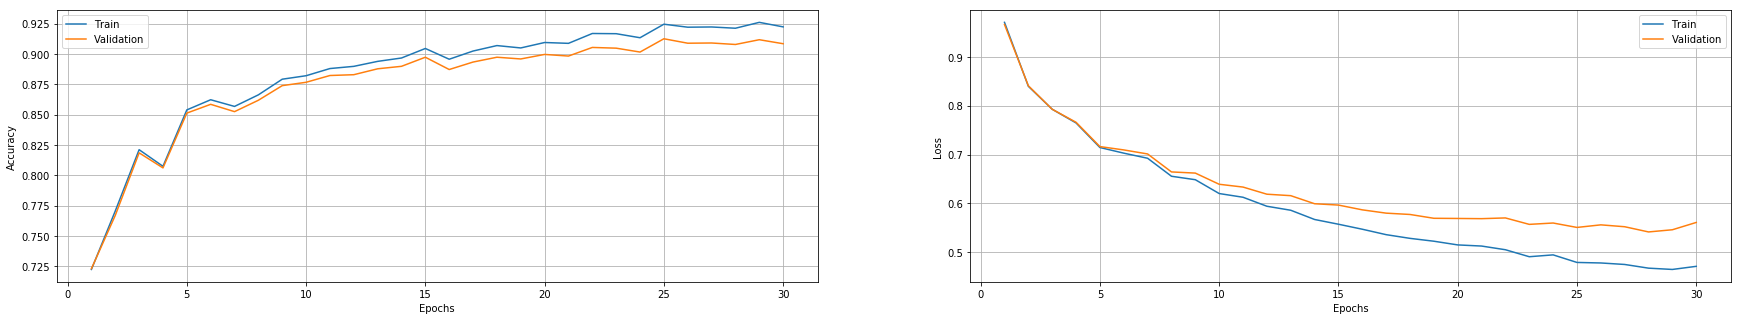

Accuracy: 0.9132932079081633
Loss: 0.5206035375595093


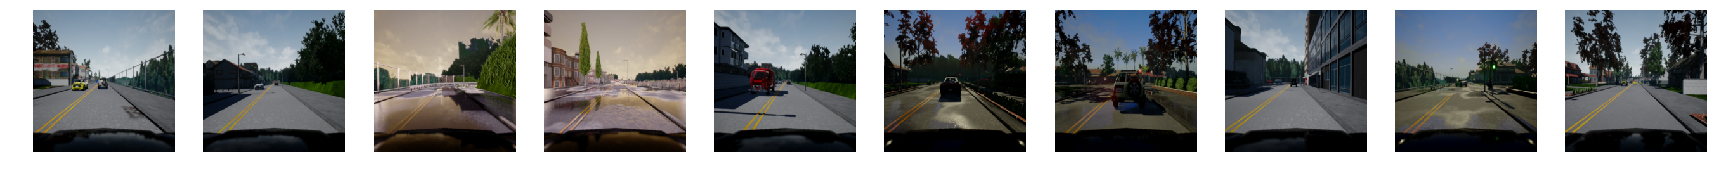

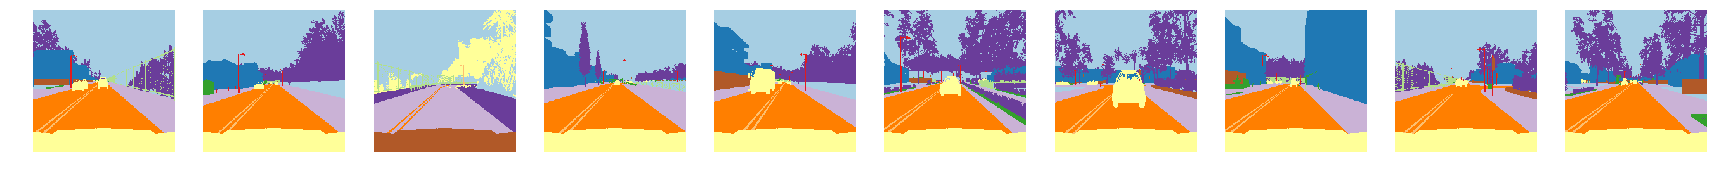

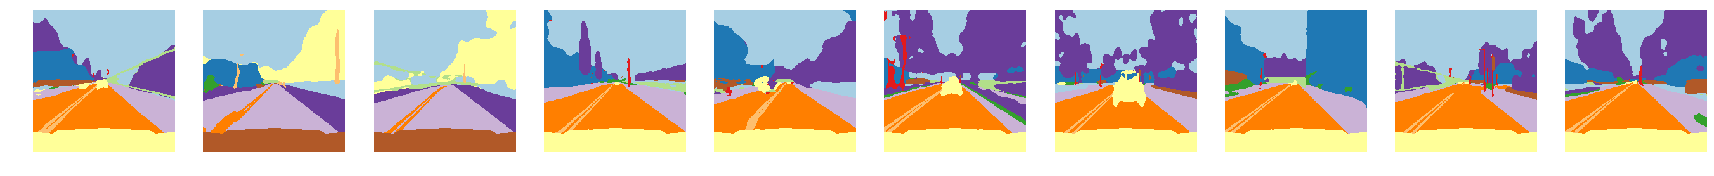

In [6]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary

# from SegmentationAgent import SegmentationAgent

VAL_PERCENTAGE = 0.2
TEST_NUM = 10
NUM_CLASSES = 13
BATCH_SIZE = 16
IMG_SIZE = 224
DATA_PATH = Path('../input')
SHUFFLE = True
LR = 0.001
EPOCHS = 30
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

params = {
    'batch_size': BATCH_SIZE,
    'num_classes': NUM_CLASSES,
    'epochs': EPOCHS,
    'image_size': IMG_SIZE,
    'lr': LR
}

agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
    'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    print(
        "Training - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    print(
        "Validation - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            engine.state.epoch, avg_accuracy, avg_loss))


summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

trainer.run(agent.train_loader, max_epochs=EPOCHS)
torch.save(agent.model.state_dict(), 'model.pt')

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
